<a href="https://colab.research.google.com/github/Sharifjjemba/Sharifjjemba/blob/main/Studying_spatial_temporal_patterns_of_electricity_asset_vandalism0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-60-52b7ea2e1caf>:33: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  vandalism_gkma = gpd.sjoin(vandalism_gdf, gkma_polygon, op='within')


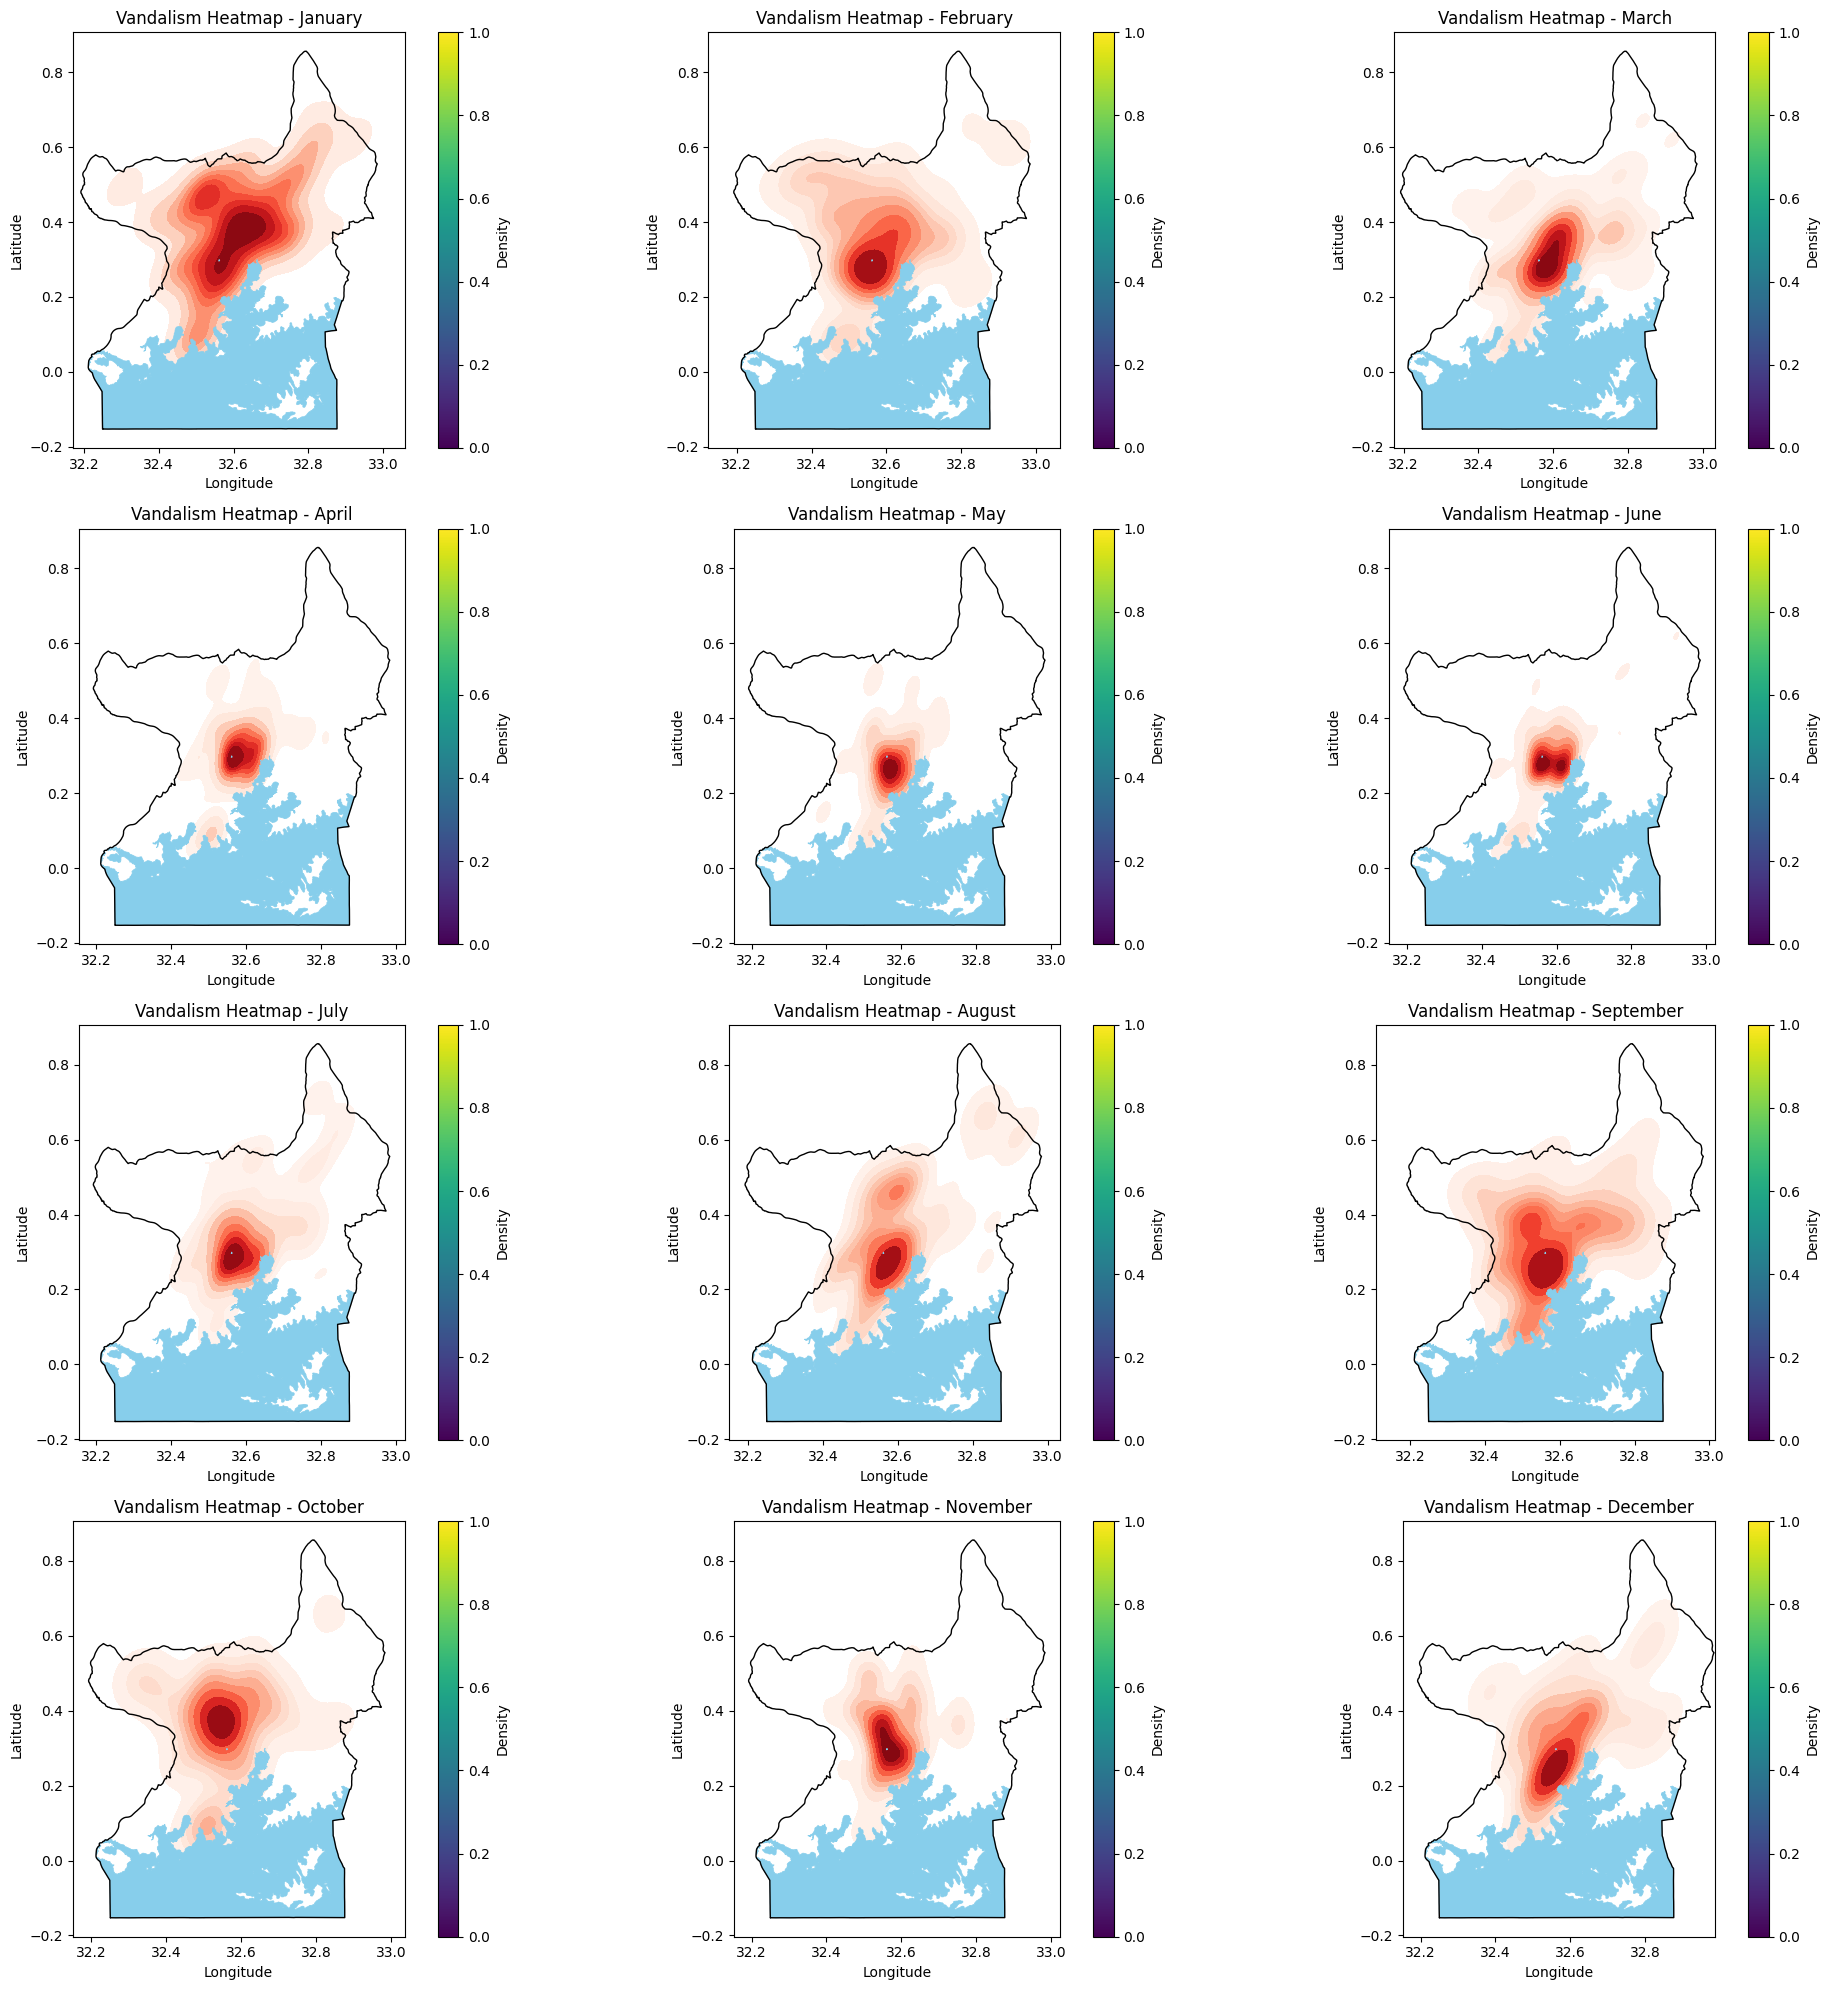

Accuracy: 0.81
F1 Score: 0.8045375304084132


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from shapely.geometry import Point, Polygon
import geopandas as gpd

# Read vandalism data from CSV file
vandalism_data = pd.read_csv('/content/drive/MyDrive/New Vandalism data.csv')

# Convert auditdate column to datetime
vandalism_data['auditdate'] = pd.to_datetime(vandalism_data['auditdate'], format='%d/%m/%Y')

# Load GKMA polygon from JSON file
gkma_polygon = gpd.read_file('/content/drive/MyDrive/GKMA.geojson')

# Load Lake Victoria polygon from GeoJSON file
lake_victoria_polygon = gpd.read_file('/content/drive/MyDrive/Lake victoria.json')

# Convert x, y columns to geometry points
vandalism_data['geometry'] = vandalism_data.apply(lambda row: Point(row['x'], row['y']), axis=1)

# Create a GeoDataFrame from vandalism data
vandalism_gdf = gpd.GeoDataFrame(vandalism_data, geometry='geometry')

# Spatial join to filter vandalism data within GKMA polygon
vandalism_gkma = gpd.sjoin(vandalism_gdf, gkma_polygon, op='within')

# Select features for Random Forest
features = ['auditdate', 'x', 'y']
X = vandalism_gkma[features]
y = vandalism_gkma['Asset']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert auditdate column to timestamp
X_train['auditdate'] = X_train['auditdate'].astype(int) // 10**9  # Convert to Unix timestamp (seconds since epoch)
X_test['auditdate'] = X_test['auditdate'].astype(int) // 10**9  # Convert to Unix timestamp (seconds since epoch)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Extract month from 'auditdate'
vandalism_data['month'] = vandalism_data['auditdate'].dt.month

# Define month names
month_names = [calendar.month_name[i] for i in range(1, 13)]

# Set up figure and axis for subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 20))

for month, ax in zip(range(1, 13), axes.flatten()):
    # Filter data for the current month
    vandalism_month = vandalism_data[vandalism_data['month'] == month]

    # Create the heatmap
    sns.kdeplot(data=vandalism_month, x='x', y='y', fill=True, cmap='Reds', ax=ax, levels=10, thresh=0.05)
    ax.set_title(f'Vandalism Heatmap - {month_names[month-1]}', fontsize=12)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)

    # Plot only the outline of GKMA polygon
    gkma_polygon.boundary.plot(ax=ax, color='black', linewidth=1.0)

    # Plot Lake Victoria polygon with the same color for both facecolor and edgecolor
    lake_victoria_polygon.plot(ax=ax, facecolor='skyblue', edgecolor='skyblue', linewidth=0.5)

    # Add colorbar
    colorbar = plt.colorbar(ax.collections[0], ax=ax, cmap='Reds')
    colorbar.set_label('Density')

# Adjust layout
plt.tight_layout()
plt.show()

# Evaluate model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
